In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as md
from tqdm import trange
import pickle
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from utils.portfolio_backtests import *
from utils.trading_model import *
from utils.experiment_utils import *
from utils.portfolio_backtests import MeanVariance

from cvx.covariance.ewma import iterated_ewma, _ewma_cov, _ewma_mean
from cvx.covariance.combination import from_sigmas

import datetime
import random

sns.set()
sns.set(font_scale=1.5)

boolUniformlyDistributedDataset = True
percentageOfRemovedDays = 40

In [6]:
def count_extreme_values(original_returns, interpolated_returns, threshold=0.20):
    '''
    this is just a testing function to see how many values are greater than 10% and lower than -10% in the original and interpolated dataset
    '''
    # Count values greater than +10% and lower than -10% in the original dataset
    count_greater_original = (original_returns > threshold).sum().sum()
    count_lower_original = (original_returns < -threshold).sum().sum()

    # Count values greater than +10% and lower than -10% in the interpolated dataset
    count_greater_interpolated = (interpolated_returns > threshold).sum().sum()
    count_lower_interpolated = (interpolated_returns < -threshold).sum().sum()

    return (count_greater_original, count_lower_original), (count_greater_interpolated, count_lower_interpolated)


# code to make the dataset not uniformly distributed
def removeRandomDays(returnDataset, D):
    '''
    returnDataset: dataframe of returnDataset
    D: percentage of days to eliminate randomly from the dataset:10 = 10% of the days are eliminated
    '''

    # calculate the size of the dataset(so the lenght of the column)
    datasetSize = len(returnDataset.index)
    number_of_days_to_eliminate = int(datasetSize * D / 100)

    # Define the range of indices that can be removed; avoid the first and last days
    valid_indices = list(range(2, datasetSize - 2)) # Randomly select a group of indices to remove

    #Randomly select a group of indices to remove
    indices_to_remove = sorted(random.sample(valid_indices, number_of_days_to_eliminate))
    print("len of indices to remove and interpolate: " + str(len(indices_to_remove)))
    
    # Create a copy of the DataFrame to perform interpolation
    interpolatedReturns = returnDataset.copy()

    # Interpolate the returns using linear interpolation method
    interpolatedReturns.iloc[indices_to_remove] = np.nan
    interpolatedReturns = interpolatedReturns.interpolate(method='linear', axis=0, limit_area='inside')
    # limit the number of decimals to 6
    interpolatedReturns = interpolatedReturns.round(6)

    ################### testing part -> then delete it ##################

    # save the interpolated dataset in a csv file
    interpolatedReturns.to_csv("interpolatedReturns.csv")
    '''
    numberOfChanges = 0
    for idx in interpolatedReturns.index:
        # Check if the values at the current index are different
        if not interpolatedReturns.loc[idx].equals(returnDataset.loc[idx]):
            print(f"Date: {idx}")
            print(f"Original Returns: {returnDataset.loc[idx].to_dict()}")
            print(f"Interpolated Returns: {interpolatedReturns.loc[idx].to_dict()}\n")
            numberOfChanges += 1
    
    print("number of changes: " + str(numberOfChanges))
    # now plot the 2 datasets
    # Plot the returns of the two datasets in 2 separate plots
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 1, 1)
    plt.plot(returns)
    plt.title("Original Returns")
    plt.xlabel("Date")
    plt.ylabel("Returns")

    plt.subplot(2, 1, 2)
    plt.plot(interpolatedReturns)
    plt.title("Interpolated Returns")
    plt.xlabel("Date")
    plt.ylabel("Returns")

    plt.legend()
    plt.show()

    # print the max and min values of the returns
    print("max value of interpolatedReturns: " + str(interpolatedReturns.max().max()))
    print("min value of interpolatedReturns: " + str(interpolatedReturns.min().min()))

    # print the max and min values of the returns
    print("max value of returns: " + str(returns.max().max()))
    print("min value of returns: " + str(returns.min().min()))

    # Assuming 'returns' and 'interpolatedReturns' are defined
    extreme_counts_original, extreme_counts_interpolated = count_extreme_values(returns, interpolatedReturns)

    print("Original dataset - Count of returns > +10%: ", extreme_counts_original[0])
    print("Original dataset - Count of returns < -10%: ", extreme_counts_original[1])
    print("Interpolated dataset - Count of returns > +10%: ", extreme_counts_interpolated[0])
    print("Interpolated dataset - Count of returns < -10%: ", extreme_counts_interpolated[1])
    ##############################################################
    '''
    # TODO: ask what happens with the risk free rate dataset; if i have to linear interpolate it too

    return interpolatedReturns

# Import data

In [7]:
returns = pd.read_csv('data/SP500_top25_adjusted.csv', index_col=0, parse_dates=True)
uniformlyDistributedReturns = returns.copy() # this is a copy of the original dataset returns; i will use this to make it non-uniformly distributed

# Risk-free rate
FF = pd.read_csv('data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

In [8]:
print("original returns dataframe dimention: " + str(uniformlyDistributedReturns.shape))

if not boolUniformlyDistributedDataset:

    # if i consider the non-uniformly distributed dataset, i have to apply the linear interpolation to the data to fill the missing values;
    # so i will have not the original dataset with real values, but a dataset with interpolated values
    returns = removeRandomDays(uniformlyDistributedReturns, percentageOfRemovedDays) 
    print("returns dataframe dimention after interpolating random days: " + str(returns.shape))

# if we use returns
# Import pkl /Users/kasper/Documents/Stanford/Research/My
# papers/stat_arbs/publicRepo/cvx_stat_arb/data

with open('data/permco_to_ticker.pkl', 'rb') as f:
    permco_to_ticker = pickle.load(f)

columns = [permco_to_ticker[int(returns.columns[i])] for i in range(returns.shape[1])]

returns.columns = columns

colums = [permco_to_ticker[int(uniformlyDistributedReturns.columns[i])] for i in range(uniformlyDistributedReturns.shape[1])]
uniformlyDistributedReturns.columns = columns

original returns dataframe dimention: (3272, 25)


# Covariance predictors

In [10]:
### Parameters
rw_memory = 250
ewma_halflife=125

In [11]:
# Rolling window 

# returns a dictionary where each key is a time period, and the corresponding value is the DataFrame representing the covariance matrix for that period.
# It only includes the periods after the min_periods threshold is met, ensuring that there's sufficient data to provide meaningful covariance estimates.

# Furthermore: inside the rolling window function there is the implementation of formula to calculate the covariance matrix written inside the paper;
# So the covariance matrix calculated at time t(i know the time from the key of the dictionary) is calculated using the formula written inside the paper
rwDict = rolling_window(returns, rw_memory) 

# print just the first key and value of the dictionary
#print(list(rwDict.keys())[0])
#print(rwDict[list(rwDict.keys())[0]])

In [12]:
# EWMA

# ewma is a dictionary that contains the covariance matrix calculated using the ewma formula written inside the paper
# the key of the dictionary is the timestamp and the value is the covariance matrix calculated for that day
beta = 2 ** (-1 / ewma_halflife)
print("decay factor used: " + str(beta) + "\n")

ewmaDict = dict(_ewma_cov(returns, halflife=ewma_halflife))

# print just the first key and value of the dictionary
#print(list(ewmaDict.keys())[0])
#print(ewmaDict[list(ewmaDict.keys())[0]])

Next we import the precomputed MGARCH predictors (computed using the rmgarch
package in R). We used the first 250 days for training. Hence the first
predictors is given at day 250, and predicts the covariance matrix for day 251.
(Python uses zero-based indexing, so the first predictor will have time index 249.)

In [41]:
# MGARCH precomputed in R due to computational complexity
# The covariance matrices were computed for 100*r for numerical reasons 

mgarch_cond_cov = pd.read_csv("mgarch_predictors_from_R/stocks/mgarch_stocks_adj.csv", index_col=None)

# here we are obtaining the covariance matrix calculated for every day from the csv file;
# so this covariance matrix estimation is done with real returns and not with interpolated returns
Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, returns.shape[1]) / 10000 # returns.shape[1] gives the number of columns in the returns DataFrame, which corresponds to the number of assets in the portfolio

# Remove first year since it was used for training
times = returns.index[249:] 
mgarch = {times[t]: pd.DataFrame(Sigmas[t], index=returns.columns, columns=returns.columns) for t in range(Sigmas.shape[0])}

# print just the first key and value of the dictionary
print(list(mgarch.keys())[0]) # TODO: delete this print
print(mgarch[list(mgarch.keys())[0]]) # TODO: delete this print


2010-12-29 00:00:00
           XOM       WMT      AAPL        PG       JNJ       CMB       IBM  \
XOM   0.000035  0.000020  0.000033  0.000022  0.000021  0.000067  0.000026   
WMT   0.000020  0.000057  0.000026  0.000021  0.000018  0.000043  0.000021   
AAPL  0.000033  0.000026  0.000132  0.000031  0.000029  0.000094  0.000047   
PG    0.000022  0.000021  0.000031  0.000044  0.000022  0.000053  0.000025   
JNJ   0.000021  0.000018  0.000029  0.000022  0.000035  0.000051  0.000026   
CMB   0.000067  0.000043  0.000094  0.000053  0.000051  0.000344  0.000072   
IBM   0.000026  0.000021  0.000047  0.000025  0.000026  0.000072  0.000053   
SBC   0.000028  0.000024  0.000036  0.000027  0.000026  0.000069  0.000031   
GE    0.000052  0.000044  0.000075  0.000049  0.000045  0.000186  0.000060   
CHV   0.000048  0.000030  0.000060  0.000031  0.000035  0.000117  0.000044   
PFE   0.000031  0.000026  0.000048  0.000023  0.000029  0.000085  0.000036   
WFC   0.000056  0.000036  0.000081  0.000048

In [16]:
# PRESCIENT 

# prescient is a dictionary that contains the covariance matrix calculated using the ewma formula written inside the paper
# the key of the dictionary is the timestamp and the value is the covariance matrix calculated for that day

# The prescient predictor will always use the original dataset, so it will be uniformly distributed; this is because the prescient predictor is used to compare the other predictors
# and we need to have a measure of the real covariance matrix; so this can't be used with the non-uniformly distributed dataset

prescientDict = {}
for t in uniformlyDistributedReturns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(uniformlyDistributedReturns.loc[(uniformlyDistributedReturns.index.year == t.year) & (uniformlyDistributedReturns.index.quarter == quarter)].values, rowvar=False)
    mean = np.mean(uniformlyDistributedReturns.loc[(uniformlyDistributedReturns.index.year == t.year) & (uniformlyDistributedReturns.index.quarter == quarter)].values, axis=0)
    prescientDict[t] = pd.DataFrame(cov+np.outer(mean, mean), index=uniformlyDistributedReturns.columns, columns=uniformlyDistributedReturns.columns)

# print just the first key and value of the dictionary
#print(list(prescientDict.keys())[0])
#print(prescientDict[list(prescientDict.keys())[0]])

# Define end and start dates for backtests

In [17]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("2011-12-28", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

In [18]:
names = ["RW", "EWMA", "MGARCH", "PRESCIENT"]

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [rwDict, ewmaDict, mgarch, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

# MSEs

In [19]:
for i, predictorDict in enumerate(predictors):
    if names[i] != "PRESCIENT":
        MSE_temp = MSE(returns, predictorDict).resample("Q").mean()

        print("\n" + names[i])
        print(f"mean: {MSE_temp.mean():.6f}")
        print(f"std: {MSE_temp.std():.6f}")
        print(f"max: {MSE_temp.max():.6f}")


RW
mean: 0.000336
std: 0.001622
max: 0.010913

EWMA
mean: 0.000329
std: 0.001607
max: 0.010813

MGARCH
mean: 0.000298
std: 0.001432
max: 0.009628


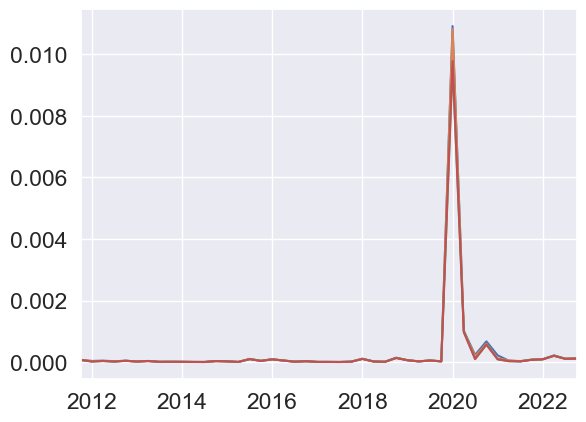

In [20]:
plt.figure()
for i, predictorDict in enumerate(predictors):
    MSE_temp = MSE(returns, predictorDict).resample("Q").mean()
    MSE_temp.plot()

# Log likelihoods

In [21]:
'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

log_likelihoods = {}
for i, predictorDict in enumerate(predictors):
    print("Computing " + names[i] + " log-likelihood...")

    # if the predictor is the prescient predictor, i have to use the uniformly distributed dataset
    if names[i] == "PRESCIENT":
        returns_temp = uniformlyDistributedReturns.loc[pd.Series(predictorDict).index].values[1:]
    
    else:
        returns_temp = returns.loc[pd.Series(predictorDict).index].values[1:]

    times = pd.Series(predictorDict).index[1:]
    Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)


'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        MGARCH: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]

Computing RW log-likelihood...
Computing EWMA log-likelihood...
Computing MGARCH log-likelihood...
Computing PRESCIENT log-likelihood...


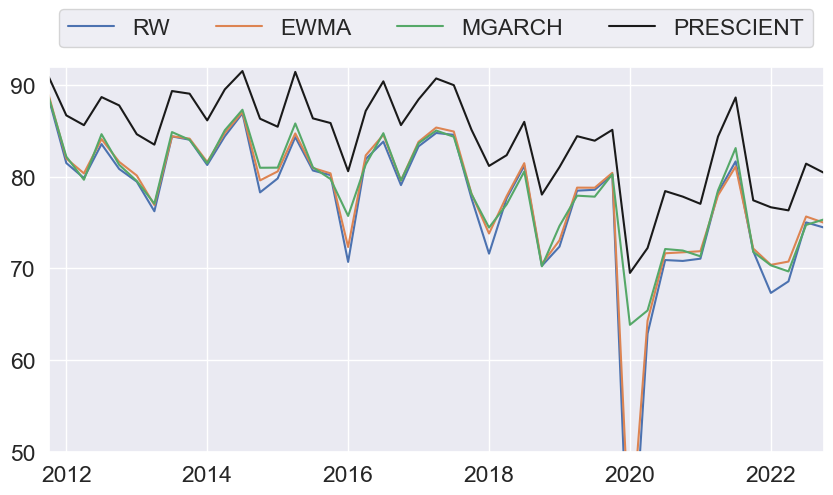

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5);
plt.ylim(50,92);

# Regrets

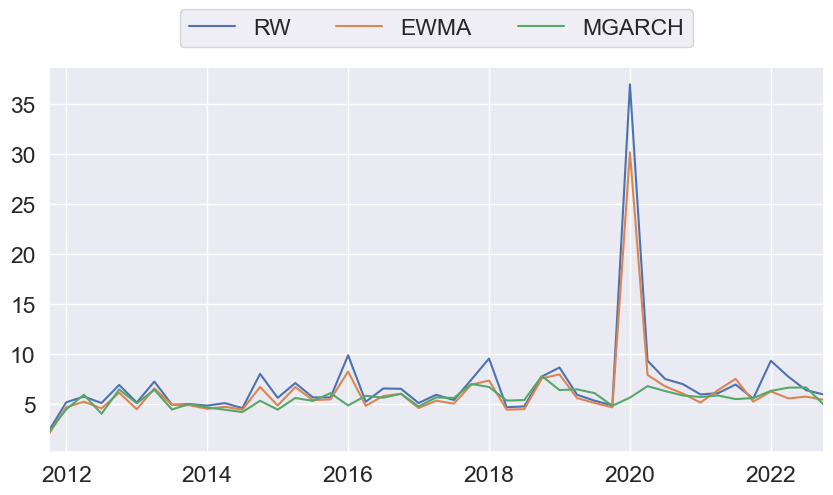

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);


### Compare CM-IEWMA with MGARCH

In [24]:
#regret_mgarch = regrets["MGARCH"].resample("Q").mean()
#regret_cm_iewma = regrets["CM-IEWMA"].resample("Q").mean()

#regret_mgarch.plot(label="MGARCH")
#regret_cm_iewma.plot(label="CM-IEWMA");
#plt.legend();

In [25]:
#cm_iewma_advantage = (regret_cm_iewma - regret_mgarch < 0).mean()
#print(f"CM-IEWMA is better than MGARCH {cm_iewma_advantage:.0%} of the time")

### Regret CDF plots

In [26]:
'''
for name in log_likelihoods:
    if name != "PRESCIENT":
        data = regrets[name].resample("Q").mean().values
        x, y = ecdf(data)
        plt.plot(x, y, label=name)
plt.xlim(4.5,8)
plt.ylim(-0.1,1.1)
plt.legend();
'''

'\nfor name in log_likelihoods:\n    if name != "PRESCIENT":\n        data = regrets[name].resample("Q").mean().values\n        x, y = ecdf(data)\n        plt.plot(x, y, label=name)\nplt.xlim(4.5,8)\nplt.ylim(-0.1,1.1)\nplt.legend();\n'

### Regret metrics

In [27]:
print("\\begin{tabular}{lccccc}")
print("   \\toprule")
print("   Predictor & Average & Std.~dev. & Max \\\\")
print("   \\midrule")

for name in regrets:
    if name != "PRESCIENT":
        print("   {}".format(name), end=" & ")
        
        #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
        regret = regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
        # so the regret variable is a series of average regret for each quarter
        
        metrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        # the round(1) function to each of these metrics, which rounds the result to one decimal place,
        print("{} & {} & {} \\\\".format(metrics[0], metrics[1], metrics[2]))

print("   \\hline")
print("   PRESCIENT & 0.0 & 0.0 & 0.0 \\\\")
print("   \\bottomrule")
print("\\end{tabular}")


\begin{tabular}{lccccc}
   \toprule
   Predictor & Average & Std.~dev. & Max \\
   \midrule
   RW & 7.0 & 4.8 & 37.0 \\
   EWMA & 6.2 & 3.8 & 30.2 \\
   MGARCH & 5.6 & 1.0 & 7.8 \\
   \hline
   PRESCIENT & 0.0 & 0.0 & 0.0 \\
   \bottomrule
\end{tabular}


# Portfolio optimization

In [28]:
# Risk-free rate for backtest period; for cash allocation end_date removed since
# it is removed in returns (in shift(-1)) to make predictors causal
rf = rf_rate.loc[start_date:end_date].iloc[:-1]

# Portfolio paramaters
additonal_cons={"short_lim":1.6, "upper_bound":0.15,\
             "lower_bound":-0.1}
sigma_tar = 0.1
excess = True

### Equally weighted

In [29]:
# just creates the object for every trader; traders_eq_w is a dictionary that for every predictor name(key) has a value associated
# that is the memory address of the just created object

# this is a class initialization; so traders eq w is an instance of the class EqWeighted

'''
so the parameter of the class EqWeighted are:
returns: dataframe of returns taken from the csv file(in this case SP500_top25_adjusted.csv)
predictors: list of distionaries where each dictionary is a predictor -> RW,EWMA,IEWMA,MGARCH,CM-IEWMA,PRESCIENT ARE ALL DICTIONARIES
names: list of strings that contains the names of the predictors
start_date: start date of the backtest
end_date: end date of the backtest
'''
# after this assignment, traders_eq_w is a dictionary with keys being the names of the predictors and values being the trader instances
# and every trader instance contains returns(the one take from the csv file), covariance matrices and the weights WS(weights that must be assigned to every asset) for the eq_weighted portfolio strategy
# the weights are the portfolio weights: so equal weights are equeally distributed among the assets; minimum variance weights are the weights that minimize the variance of the portfolio; etc.
print("start_date: " + str(start_date) + " - " + str(type(start_date)))

traders_eq_w = EqWeighted(returns, predictors, names, start_date, end_date).backtest()
# print("traders_eq_w: ", traders_eq_w) #traders_eq_w:  {'RW': <utils.trading_model.Trader object at 0x00000292178F8E10>, 'EWMA': <utils.trading_model.Trader object at 0x00000292014297D0>, 'IEWMA': <utils.trading_model.Trader object at 0x0000029217729E90>, 'MGARCH': <utils.trading_model.Trader object at 0x0000029217529950>, 'CM-IEWMA': <utils.trading_model.Trader object at 0x000002921792A110>, 'PRESCIENT': <utils.trading_model.Trader object at 0x0000029217911E10>}

# print the dimension of the dictionary
# print("traders_eq_w dimension: " + str(len(traders_eq_w))) -> is 6 as the predictor list dimension

# print everything about the first dictionary object
# print("traders_eq_w first object: " + str(traders_eq_w['RW'])) -> traders_eq_w first object: <utils.trading_model.Trader object at 0x000001E8F8AEA0D0>

start_date: 2011-12-28 00:00:00 - <class 'pandas._libs.tslibs.timestamps.Timestamp'>


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:14<00:00,  3.75s/it]


In [30]:
#trader = traders_eq_w["CM-IEWMA"]
#SRs = yearly_SR(trader)

In [31]:
create_table(traders_eq_w, sigma_tar, rf, excess) # inside this function all the metrics are calculated and printed



name:  RW
the trader object is:  <utils.trading_model.Trader object at 0x000002214993E710>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  0.9999999999999999


name:  EWMA
the trader object is:  <utils.trading_model.Trader object at 0x000002214992C510>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0


name:  MGARCH
the trader object is:  <utils.trading_model.Trader object at 0x0000022149954F10>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0000000000000002


name:  PRESCIENT
the trader object is:  <utils.trading_model.Trader object at 0x000002213FEF9910>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  0.9999999999999999
metrics before calling _create_table_helper function:  {'R

### Minimum risk

In [32]:
traders_min_risk = MinRisk(returns, predictors, names, start_date, end_date).backtest(additonal_cons)

100%|██████████| 4/4 [01:46<00:00, 26.62s/it]


In [33]:
#trader = traders_min_risk["CM-IEWMA"]
#SRs = yearly_SR(trader)
#plt.legend().remove()

In [34]:
create_table(traders_min_risk, sigma_tar, rf, excess)



name:  RW
the trader object is:  <utils.trading_model.Trader object at 0x00000221471B3D50>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  0.9999999999999983


name:  EWMA
the trader object is:  <utils.trading_model.Trader object at 0x0000022142E25250>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0000000000000004


name:  MGARCH
the trader object is:  <utils.trading_model.Trader object at 0x00000221470131D0>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  0.9999999999999991


name:  PRESCIENT
the trader object is:  <utils.trading_model.Trader object at 0x000002210775A710>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.000000000000001
metrics before calling _create_table_helper 

### Maximum diversification 

In [35]:
traders_max_diverse = MaxDiverse(returns, predictors, names, start_date, end_date).backtest(additonal_cons)

100%|██████████| 4/4 [02:03<00:00, 30.80s/it]


In [36]:
create_table(traders_max_diverse, sigma_tar, rf, excess)



name:  RW
the trader object is:  <utils.trading_model.Trader object at 0x000002214419A1D0>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0


name:  EWMA
the trader object is:  <utils.trading_model.Trader object at 0x0000022142E2DC90>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0


name:  MGARCH
the trader object is:  <utils.trading_model.Trader object at 0x0000022177541990>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0


name:  PRESCIENT
the trader object is:  <utils.trading_model.Trader object at 0x0000022176B27150>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  0.9999999999999999
metrics before calling _create_table_helper function:  {'RW': metrics(mean_return=0.0843

### Risk parity 

In [37]:
traders_risk_par = RiskParity(returns, predictors, names, start_date, end_date).backtest()

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [01:59<00:00, 29.79s/it]


In [38]:
create_table(traders_risk_par, sigma_tar, rf, excess)



name:  RW
the trader object is:  <utils.trading_model.Trader object at 0x00000221471D6810>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0


name:  EWMA
the trader object is:  <utils.trading_model.Trader object at 0x00000221470125D0>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0


name:  MGARCH
the trader object is:  <utils.trading_model.Trader object at 0x00000221662EA2D0>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0


name:  PRESCIENT
the trader object is:  <utils.trading_model.Trader object at 0x000002214706F410>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0
metrics before calling _create_table_helper function:  {'RW': metrics(mean_return=0.07370633748846439, 

### Mean variance

In [39]:
def tune_returns(returns):
    """
    Cuts element in each row at its 40th and 60th percentile
    up and down
    """
    
    returns_tuned = np.zeros_like(returns)

    for t in range(returns.shape[0]):
        r_temp = returns.iloc[t]
        returns_tuned[t] = np.clip(r_temp, a_min=r_temp.quantile(0.4), a_max=r_temp.quantile(0.6))

    return pd.DataFrame(returns_tuned, index=returns.index, columns=returns.columns)

In [40]:
r_hat_ewma = pd.DataFrame(dict(_ewma_mean(returns, halflife=250))).T
r_hat_ewma = tune_returns(r_hat_ewma)

mean_predictors = [r_hat_ewma for name in names]

traders_mean_var = MeanVariance(returns, predictors, names, mean_predictors=mean_predictors, start_date=start_date, end_date= end_date).backtest(additonal_cons, sigma_tar, rhos=None)
create_table(traders_mean_var, None, rf, excess, prescient=True)

 25%|██▌       | 1/4 [02:52<08:38, 172.73s/it]


ValueError: cannot reshape array of size 26 into shape (25,1)

In [ ]:
trader = traders_mean_var["CM-IEWMA"]
trader.returns = trader.R
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
# 63 day halfife
trader = traders_mean_var["No clip"]
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
# 63 day halfife
trader = traders_mean_var["clip"]
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
# 63 day half-life
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
# 250 day halfife
trader = traders_mean_var["No clip"]
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
# 250 day halfife
trader = traders_mean_var["clip"]
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
# 250 day half-life
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
# 250 day half-life clip at 70th and 30th percentile
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
create_table(traders_mean_var, None, rf, excess)